# Quadcopter + LQR

## Setup problem

In [1]:
# Import template copied over from some tutorials
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")
#
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  from mujoco import minimize
  from mujoco import rollout
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
print('MuJoCo installation successful.')

from IPython.display import clear_output
clear_output()

# Other imports.
import mediapy as media
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from typing import Tuple, Optional, Union
import scipy

np.set_printoptions(precision=3)

""

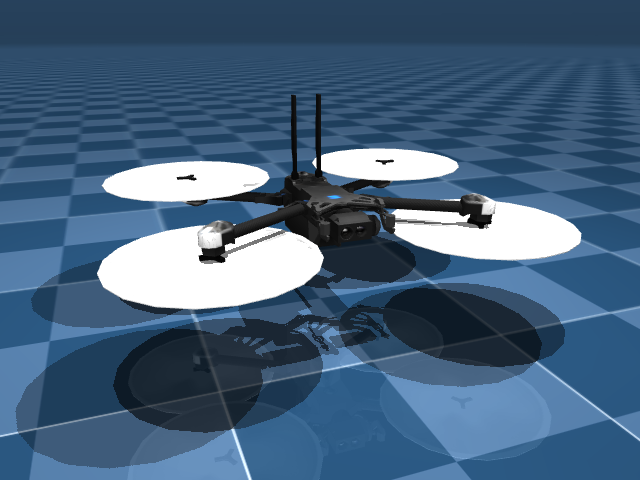

In [2]:
model = mujoco.MjModel.from_xml_path('skydio_x2/scene.xml')
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
with mujoco.Renderer(model, height=480, width=640) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  
  media.show_image(renderer.render())

In [3]:
duration = 5   # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
data.qpos = np.array([0, 0, .3, 1, 0, 0, 0]) #where we are  # Save the position setpoint.

# Visualize
with mujoco.Renderer(model, height=480, width=640) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

## Implement LQR

In [4]:
# Finding the control setpoint
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

actuator_moment = np.zeros((model.nu, model.nv))
mujoco.mju_sparse2dense(
    actuator_moment,
    data.actuator_moment.reshape(-1),
    data.moment_rownnz,
    data.moment_rowadr,
    data.moment_colind.reshape(-1),
)
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)

desired forces: [ 0.     0.    12.998  0.     0.     0.   ]
control setpoint: [3.25 3.25 3.25 3.25]


In [5]:
# Linearize the dynamics
nu = model.nu  # Alias for the number of actuators.
nv = model.nv  # Alias for the number of DoFs.

# Finite-difference parameters
epsilon = 1e-6
centered = True

# Compute the Jacobians
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))
mujoco.mjd_transitionFD(model, data, epsilon, centered, A, B, None, None)

In [112]:
# Design controller
Q = np.zeros(A.shape) # Weights for the state
np.fill_diagonal(Q, 1)
R = np.eye(model.nu) # Weights for the controls
Q[0, 0] = 15.
Q[1, 1] = 15.
Q[2, 2] = 15.
print(Q)

# Solve discrete Riccati equation.
P = scipy.linalg.solve_discrete_are(A, B, Q, R)

# Compute the feedback gain matrix K.
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

[[15.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 15.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 15.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [116]:
# Simulate everything
DURATION = 3         # seconds
FRAMERATE = 60        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
qpos0 = np.array([0, 0, .2, 1, 0, 0, 0]) #where we are  # Save the position setpoint.
data.qpos = np.array([0, 0, .0, 1, 0, 0, 0])
data.ctrl = ctrl0 #how we get there (kind of)

# Allocate position difference dq.
dq = np.zeros(model.nv)

frames = []
# Visualize
with mujoco.Renderer(model, height=480, width=640) as renderer:
  while data.time < DURATION:
    # Get state difference dx.
    mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
    dx = np.hstack((dq, data.qvel)).T

    # LQR control law.
    data.ctrl = ctrl0 - K @ dx

    # Step the simulation.
    mujoco.mj_step(model, data)

    # Render and save frames.
    if len(frames) < data.time * FRAMERATE:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)

  media.show_video(frames, fps=FRAMERATE)
  print("NOTE: The syste destablizes eventually, but I don't want to spend more time tweaking Q")

NOTE: The syste destablizes eventually, but I don't want to spend more time tweaking Q
